In [1]:


# from dask.distributed import Client, LocalCluster
# cluster = LocalCluster()
# client = Client(cluster)
# print(client)


In [2]:
# loadings and defaults
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob
import repackage

import numpy.matlib
from xgcm import Grid
import matplotlib.ticker as mticker

%config InlineBackend.figure_format='png'



In [3]:
# load tisom history file

ds = xr.open_dataset('../data/proc/tisom_his_0021_trimmed.nc')


In [4]:
# make the vertical coordinate. Note that it is time varying, as the ocean free-surface (zeta) moves each time step
z_rho = ds.zeta + (ds.zeta + ds.h) * ((ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h))
ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
del z_rho #clear up some memory

# make the vertical coordinate at cell top/bottom faces.
z_w = ((ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)) * (ds.zeta + ds.h) + ds.zeta
ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
del z_w

(109.0, 111.0, -67.0, -66.0)

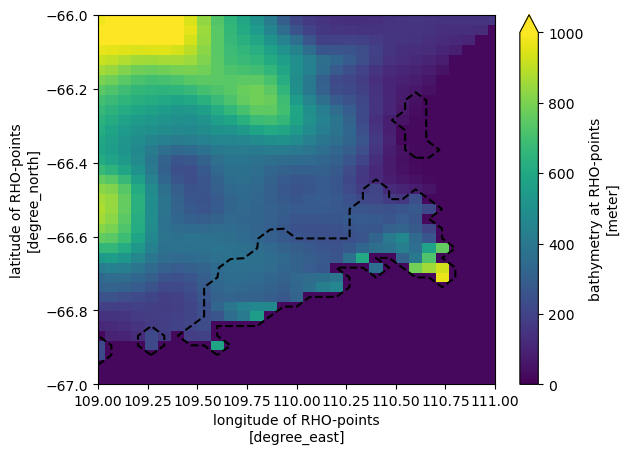

In [5]:
ds.h.plot(x='lon_rho',y='lat_rho',vmin=0,vmax=1000)
ds.zice.plot.contour(x='lon_rho',y='lat_rho',levels=[-1],colors='k')

plt.axis((109,111,-67,-66))


(109.0, 111.0, -67.0, -66.0)

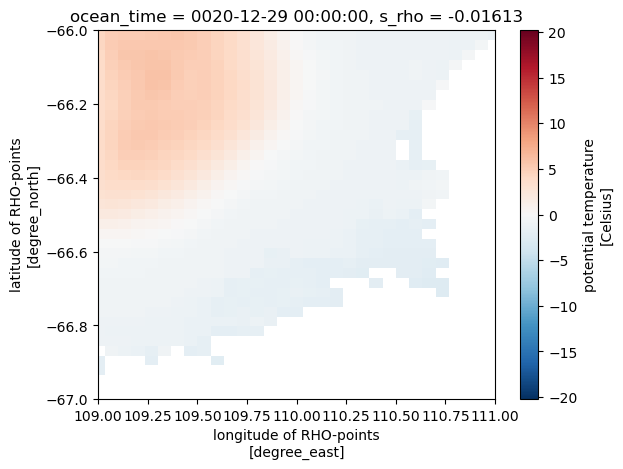

In [6]:
ds.temp.isel(ocean_time=0,s_rho=-1).plot(x='lon_rho',y='lat_rho')
plt.axis((109,111,-67,-66))

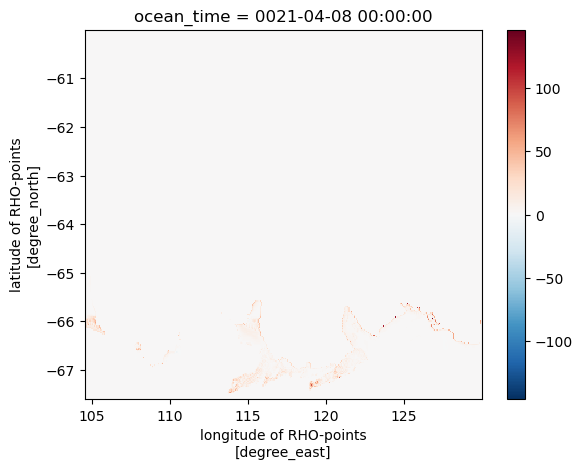

In [7]:
(ds.m*(60*60*24*365)*ds.mask_rho).isel(ocean_time=100).plot(x='lon_rho',y='lat_rho')


(109.0, 111.0, -67.0, -66.0)

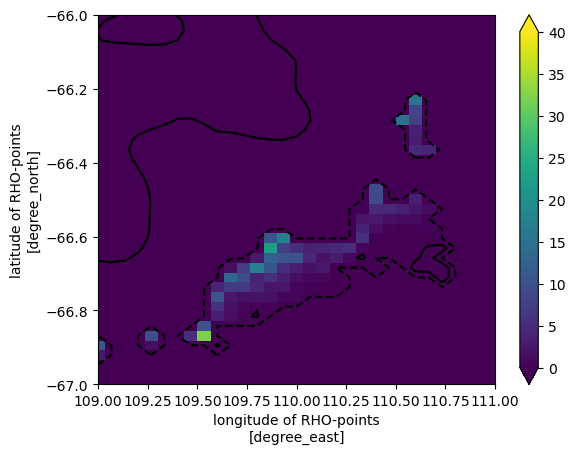

In [8]:
(ds.m*(60*60*24*365)*ds.mask_rho).isel(ocean_time=120).plot(x='lon_rho',y='lat_rho',vmin=0,vmax=40)
ds.zice.plot.contour(x='lon_rho',y='lat_rho',levels=[-1],colors='k')
ds.h.plot.contour(x='lon_rho',y='lat_rho',levels=[0,500,1000,1500,2000],colors='k')

plt.axis((109,111,-67,-66))


(109.0, 111.0, -67.0, -66.0)

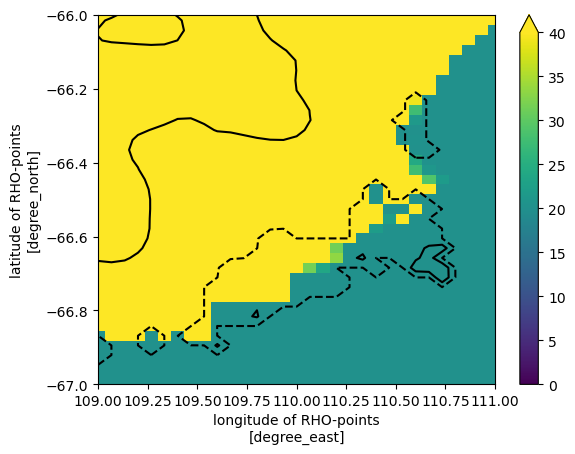

In [9]:
# (ds.m*(60*60*24*365)*ds.mask_rho).isel(ocean_time=120).plot(x='lon_rho',y='lat_rho',vmin=0,vmax=40)

(ds.h+ds.zice).plot(x='lon_rho',y='lat_rho',vmin=0,vmax=40)
ds.zice.plot.contour(x='lon_rho',y='lat_rho',levels=[-1],colors='k')
ds.h.plot.contour(x='lon_rho',y='lat_rho',levels=[0,500,1000,1500,2000],colors='k')

plt.axis((109,111,-67,-66))


In [10]:
max_lat=-63.5
min_lat=-67.63
min_lon=106.5
max_lon=113

# ds.temp.where(ds.lon_rho>min_lon).where(ds.lon_rho<max_lon).where(ds.lat_rho<max_lat).where(ds.lat_rho>min_lat).isel(ocean_time=0,s_rho=9).plot()
# plt.show()
# ds.lat_rho.where(ds.lon_rho>min_lon).where(ds.lon_rho<max_lon).where(ds.lat_rho<max_lat).where(ds.lat_rho>min_lat).plot()

box = ((min_lon < ds.lon_rho) & (ds.lon_rho < max_lon)
       & (min_lat < ds.lat_rho) & (ds.lat_rho < max_lat)).compute()


In [11]:
da_temp=ds.temp.where(box,drop=True)
da_salt=ds.salt.where(box,drop=True)
da_zeta=ds.zeta.where(box,drop=True)
da_m = ds.m.where(box,drop=True)
da_h = ds.h.where(box,drop=True)
da_zice = ds.h.where(box,drop=True)
da_pm = ds.pm.where(box,drop=True)
da_pn = ds.pn.where(box,drop=True)
da_z_w= ds.z_w.where(box,drop=True)


In [13]:


ds_out = xr.merge([da_temp,da_salt,da_zeta,da_m,da_zice,da_pm,da_pn])
ds_out = ds_out.assign_coords({'z_w':da_z_w})
ds_out.nbytes/1e9

# make the xgcm grid object we'll need for interpolation. NOTE: this is a truncated version for memory-limit issues
def makeROMSGridObject(ds):
    # ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho'}, 
        'Y':{'center':'eta_rho'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])
    
    ds['dx'] = 1/ds.pm
    ds['dy'] = 1/ds.pn
    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    
    ds['dA'] = ds.dx * ds.dy
    
    gridOut = Grid(ds, 
    coords={'X':{'center':'xi_rho'}, 
    'Y':{'center':'eta_rho'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    metrics = {
        ('X',): ['dx'],# 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy'],# 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz'],# 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    },
    periodic=False)
    
    return gridOut

grid = makeROMSGridObject(ds_out)


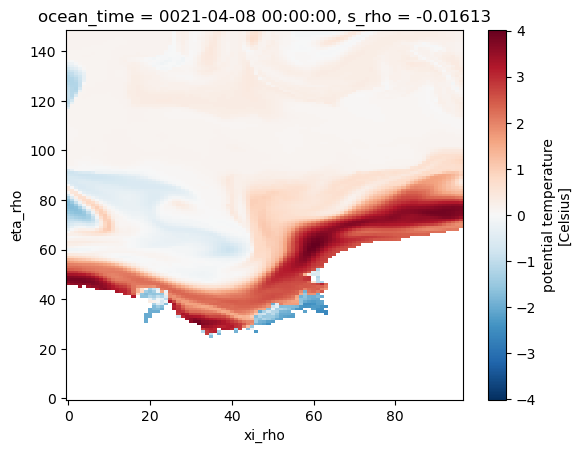

In [14]:
ds_out.temp.isel(ocean_time=100,s_rho=-1).plot()#.plot(x='lon_rho',y='lat_rho')

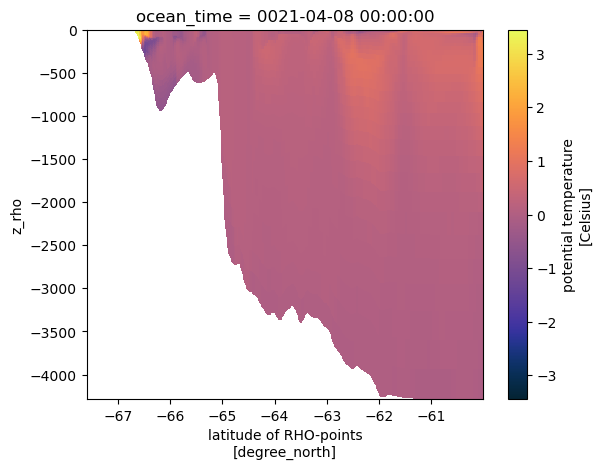

In [15]:
#plot a transect
ds.temp.isel(ocean_time=100,xi_rho=55).plot(x='lat_rho',y='z_rho',cmap='cmo.thermal')

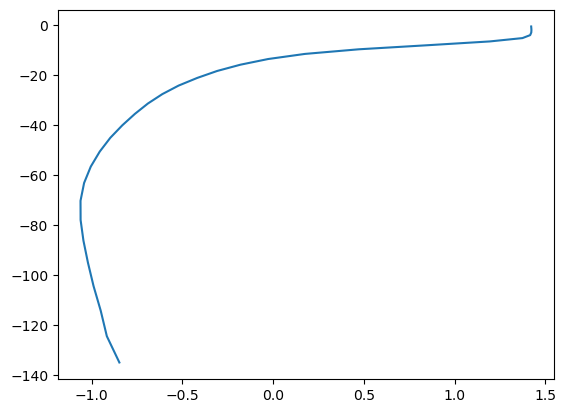

109.46666666666667
-66.6049460331263


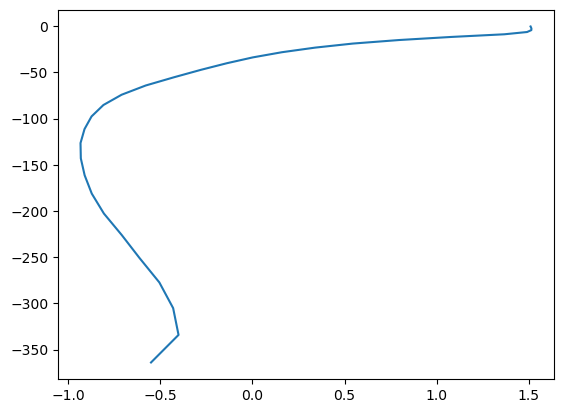

In [16]:
# extract a column of water using model coordinates
plt.plot(ds_out.temp.isel(eta_rho=60,xi_rho=55).mean(dim='ocean_time'),ds_out.z_rho.isel(eta_rho=60,xi_rho=55).mean(dim='ocean_time'))
plt.show()

# extract closest lon/lat 
target_loc =(109.5,-66.6)
A = np.abs(ds_out.lon_rho-target_loc[0]) + np.abs(ds_out.lat_rho-target_loc[1]) # add together matrices of absolute differences from point. lowest value is closest
A_i,A_j=np.unravel_index(A.argmin(),ds_out.lon_rho.shape)
print(ds_out.lon_rho[A_i,A_j].values)
print(ds_out.lat_rho[A_i,A_j].values)
plt.plot(ds_out.temp.isel(eta_rho=A_i,xi_rho=A_j).mean(dim='ocean_time'),ds_out.z_rho.isel(eta_rho=A_i,xi_rho=A_j).mean(dim='ocean_time'))

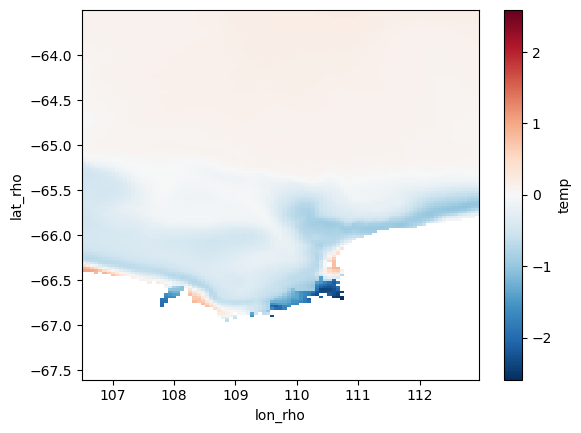

In [17]:
# let's average all depths of temperatures
grid.average(ds_out.temp,['Z']).mean(dim='ocean_time').plot(x='lon_rho',y='lat_rho')


/tmp/ipykernel_19129/1996702948.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(ds_out.lon_rho,ds_out.lat_rho,mask)


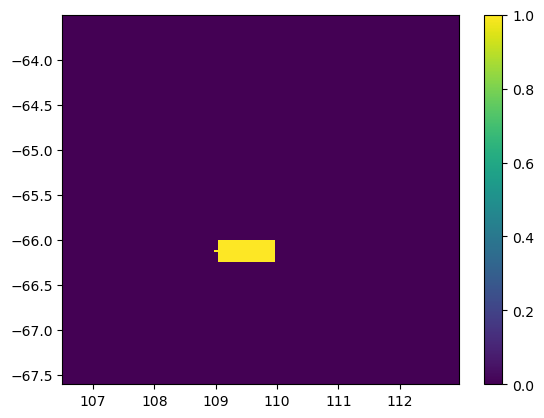

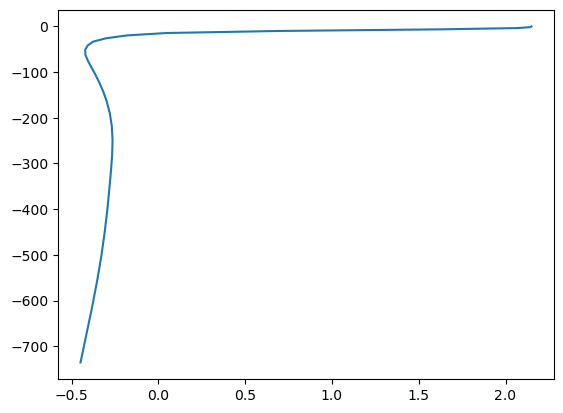

In [18]:
# now choose a box to average. Noting that different cells and columns of have different depths
weights = ds_out.dA
weights.name = "weights"

# make a mask for where we want to include in the average
mask = np.zeros_like(ds_out.lon_rho)
mask[(ds_out.lon_rho > 109) & (ds_out.lon_rho < 110) & (ds_out.lat_rho>-66.25) & (ds_out.lat_rho<-66)]=1
plt.pcolormesh(ds_out.lon_rho,ds_out.lat_rho,mask)
plt.colorbar()
plt.show()


plt.plot(ds_out.temp.mean(dim='ocean_time').where(mask==1).weighted(weights).mean(('eta_rho','xi_rho')),
         ds_out.z_rho.mean(dim='ocean_time').where(mask==1).weighted(weights).mean(('eta_rho','xi_rho')))


In [19]:
ds_out.to_netcdf('../data/proc/extract_Vincennes.nc')